In [37]:
#import torch, module for neural networks and set device

import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "CPU"
torch.__version__, DEVICE

('2.4.1+cu124', 'cuda')

## 1. Data Preparation

Various types of data:
* Excel spreadsheets
* Videos
* Images 
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation.
2. Build a model to learn patterns in that numerical representation.

In [38]:
# Creating data with linear regression
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], len(X), y[:10], len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 50,
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50)

## Splitting data into training and test sets

In [39]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Data Visualization:

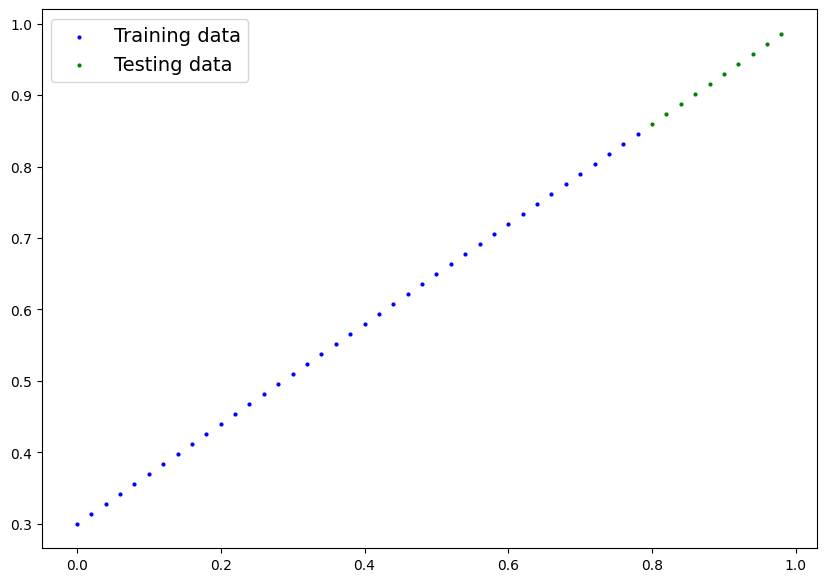

In [40]:
def plot_predictions(
    train_data = X_train.cpu(),
    train_labels = y_train.cpu(),
    test_data = X_test.cpu(),
    test_labels = y_test.cpu(),
    predictions = None
):
    """
    Plots training data, tests data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    
    # training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        # plot the prtedictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    # Show the legend
    plt.legend(prop={"size": 14})
    
plot_predictions()

## 2. Building model

What model does:
* Start with random values (eight and bias)
* Look at training data and adjust the random values, so they represent the linear corelation in the data

How does it do so?
* Gradient descent
* Backpropagation

In [41]:
# creating linear regression python class
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                                 requires_grad=True,
                                                 dtype=torch.float))
        
        self.bias = nn.Parameter(torch.randn(1,
                                             requires_grad=True,
                                             dtype=float))
        
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) ->torch.Tensor:
        return self.weights * x + self.bias
        

### PyTorch model building essentials:

* torch.nn - contains all needed to build computational graphs
* torch.nn.Parameters - what parameters should our model try and learn, often set by a layer from torch.nn
* torch.nn.Module - base class for all neural network modules, forward() needs to be overwritten
* torch.optim - contains PyTorch optimizers

In [42]:
model_0 = LinearRegressionModel()
print(list(model_0.parameters()))
print(model_0.state_dict())

[Parameter containing:
tensor([-0.5266], requires_grad=True), Parameter containing:
tensor([-0.6798], dtype=torch.float64, requires_grad=True)]
OrderedDict({'weights': tensor([-0.5266]), 'bias': tensor([-0.6798], dtype=torch.float64)})


### Making predictions with 'torch.interference_mode()'

When data is passed through model, it's going to run through forward() method.

In [43]:
# Making predictions with model
with torch.inference_mode():    # inference mode disables gradient function, can use torch.no_grad()
    y_preds = model_0(X_test)
    
y_preds

tensor([[-1.1010],
        [-1.1116],
        [-1.1221],
        [-1.1326],
        [-1.1432],
        [-1.1537],
        [-1.1642],
        [-1.1748],
        [-1.1853],
        [-1.1958]], dtype=torch.float64)

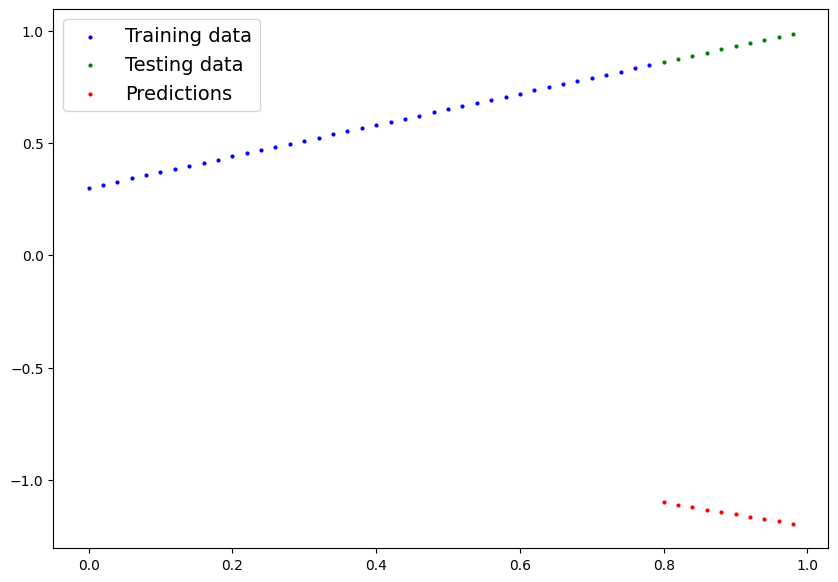

In [44]:
plot_predictions(predictions=y_preds.cpu())

## Training Model

Measure of wrongness of model is a loss function, known also as cost function or criterion.

Things to train:

1. **Loss function** - a functon to measure how wrong are the models predictions to the ideal output, lower is better.
2. **Optimizer** - takes into account the loss and adjusts the model's parameters

Testing loop and training loop are needed.

In [45]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01 )

loss_fn, optimizer

(L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

### Building a training loop and testing loop within
1. Loop through data
2. Forward pass (forward propagation) - to make predictions on data
3. Calculate the loss (compare forward pass predictions to ground truth labels)
4. Optimizer zero grad
5. Loss backward - move backwards to calculate the gradients of each of the parameters with respect to the loss
6. Optimizer step - use the optimizer to adjust model's parameters to try and improve the loss (**Gradient descent**)

In [46]:
epochs = 10001

# tracking experiment
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
    model_0.train()     # train mode sets all params that require gradient to require gradient
    
    y_pred = model_0(X_train)           # Forward pass
    
    loss = loss_fn(y_pred, y_train)     # Calculate loss function
    
    optimizer.zero_grad()               # Optimizer zero grad
    
    loss.backward()                     # backpropagation on the loss with respect to the parameters of the model
    
    optimizer.step()                    # perform gradient descent
    
    model_0.eval()                      # turns off gradient tracking for test loop
    with torch.inference_mode():                # for faster performance
        test_pred = model_0(X_test)             # predict
        test_loss = loss_fn(test_pred, y_test)  # calculate loss
    
    if (epoch)%10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())
    


Epoch: 0 | Loss: 1.458143607738796 | Test loss: 2.0579538351971616
OrderedDict({'weights': tensor([-0.5227]), 'bias': tensor([-0.6698], dtype=torch.float64)})
Epoch: 10 | Loss: 1.3429336411435113 | Test loss: 1.9232439077574714
OrderedDict({'weights': tensor([-0.4837]), 'bias': tensor([-0.5698], dtype=torch.float64)})
Epoch: 20 | Loss: 1.2277236739428667 | Test loss: 1.7885339803177818
OrderedDict({'weights': tensor([-0.4447]), 'bias': tensor([-0.4698], dtype=torch.float64)})
Epoch: 30 | Loss: 1.1125137079296585 | Test loss: 1.6538240588385567
OrderedDict({'weights': tensor([-0.4057]), 'bias': tensor([-0.3698], dtype=torch.float64)})
Epoch: 40 | Loss: 0.9973037411015433 | Test loss: 1.5191141284186345
OrderedDict({'weights': tensor([-0.3667]), 'bias': tensor([-0.2698], dtype=torch.float64)})
Epoch: 50 | Loss: 0.8820937745528248 | Test loss: 1.3844042069394091
OrderedDict({'weights': tensor([-0.3277]), 'bias': tensor([-0.1698], dtype=torch.float64)})
Epoch: 60 | Loss: 0.7668838089703532

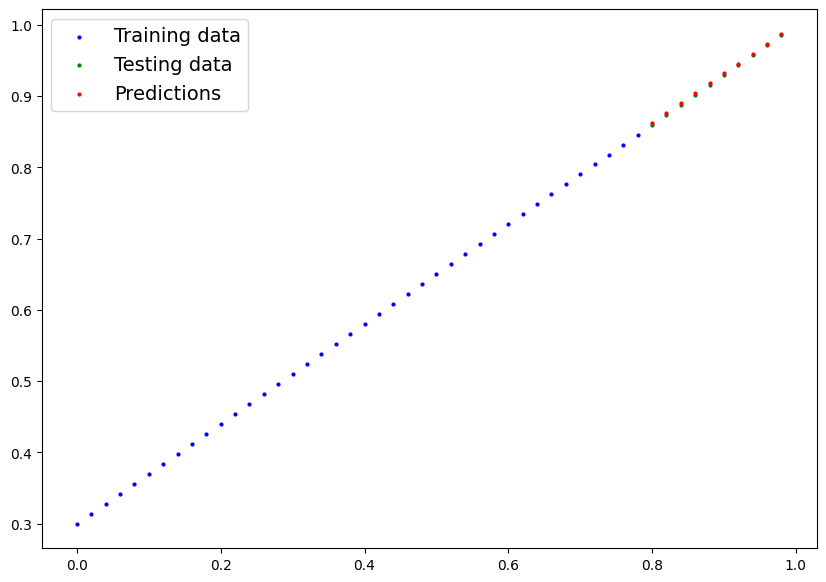

In [47]:
with torch.inference_mode():    # inference mode disables gradient function, can use torch.no_grad()
    y_preds = model_0(X_test)
    
plot_predictions(predictions=y_preds.cpu())

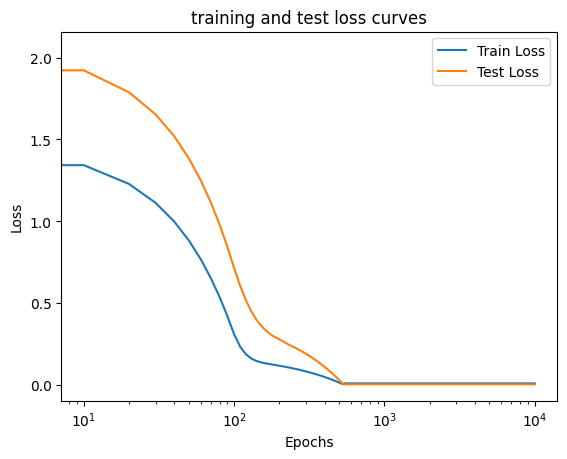

In [48]:
# plot the loss curves
plt.xscale("log")
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## Saving and loading a model in python

1. 'torch.save()' - allows you to save a PyTorch object in Python's pickle format
2. 'torch.load()' - allows you to load a saved PyTorch object
3. 'torch.nn.Module.load_state_dict()' - this allows to load a model's saved state dictionary

In [49]:
# Saving our PyTorch model
from pathlib import Path

MODEL_PATH=Path("./models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "PyTorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model_0, MODEL_SAVE_PATH)


In [50]:
# Loading PyTorch model
torch.serialization.add_safe_globals([LinearRegressionModel, set])

MODEL_PATH=Path("./models")
MODEL_NAME = "PyTorch_workflow_model_0.pth"
MODEL_LOAD_PATH = MODEL_PATH / MODEL_NAME

model_loaded = torch.load(f=MODEL_LOAD_PATH, weights_only=True)

# test if works
print(model_loaded(12))


tensor([8.6523], dtype=torch.float64, grad_fn=<AddBackward0>)
